In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
from scipy.stats import zscore
from scipy.signal import detrend
import copy
import sys
from scipy.stats import pearsonr

coherence_path = r"C:\Users\joshu\nice\testcodepearsoncoherence"
sys.path.append(coherence_path)
import coherence  
from coherence import field_field_coherence

from scipy.ndimage import gaussian_filter1d
def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 
sigma = 2


# no preprocessing!!
def preprocess(data):
    # data = detrend(data, axis=0)
    # epsilon = 1e-9
    # data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
    return data

run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0, 20)
classes_right = np.arange(0, 20)

agg_structure = {f'dataset_{file_number}': 
                 {f'left_class_{class_left}': 
                  {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

left_input_SP_attleft_agg = copy.deepcopy(agg_structure)
right_input_SP_attleft_agg = copy.deepcopy(agg_structure)
attention_SP_attleft_agg = copy.deepcopy(agg_structure)

left_input_SP_attright_agg = copy.deepcopy(agg_structure)
right_input_SP_attright_agg = copy.deepcopy(agg_structure)
attention_SP_attright_agg = copy.deepcopy(agg_structure)

n_values = {f'dataset_{file_number}':
            {f'left_class_{class_left}':
             {f'right_class_{class_right}': {
                'attleft': [],
                'attright': []
                } for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

total_time = time.time()
total_load_time = time.time()
for file_number in file_numbers:   #will first load the file and extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")
    file_process_time = time.time()

    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]

    # Extract LFP signals
    left_input_SP = data['SP'][0][0]
    right_input_SP = data['SP'][0][1]
    attention_SP = data['SP'][0][2]

    for class_left in classes_left:
         for class_right in classes_right: 
    
            left_indices = np.where((omitted ==0) & (attend_01 == 0) & (label_left == class_left) & (label_right == class_right))[0]
            right_indices = np.where((omitted ==0) & (attend_01 == 1) & (label_left == class_left) & (label_right == class_right))[0]

            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attright'] = [len(right_indices)]  #nb need both left and right indices to be non empty
          
            if len(left_indices) >= 1:
                left_input_attendingleft_t = left_input_SP[left_indices, 100:350, :]
                right_input_attendingleft_t = right_input_SP[left_indices, 100:350, :]
                attention_layer_attendingleft_t = attention_SP[left_indices, 100:350, :]

                num_trials_left, num_samples, num_neurons_left = left_input_attendingleft_t.shape
                num_neurons_attention = 80

                left_in_attleft_sm = smooth_with_gaussian(left_input_attendingleft_t, sigma=sigma) 
                right_in_attleft_sm = smooth_with_gaussian(right_input_attendingleft_t, sigma=sigma) 
                attlay_attleft_sm = smooth_with_gaussian(attention_layer_attendingleft_t, sigma=sigma) 


                for j in range(0, num_trials_left):
                    for i in range(0, num_neurons_left):
                        count_left = np.count_nonzero(left_input_attendingleft_t[j, :, i] == 1)
                        if count_left > 0:
                            left_in_attleft_sm[j, :, i] /= count_left
                        count_right = np.count_nonzero(right_input_attendingleft_t[j, :, i] == 1)
                        if count_right > 0:
                            right_in_attleft_sm[j, :, i] /= count_right


                    for i in range(0, num_neurons_attention):
                        count_attention = np.count_nonzero(attention_layer_attendingleft_t[j, :, i] == 1)
                        if count_attention > 0:
                            attlay_attleft_sm[j, :, i] /= count_attention

                left_in_attleft_sum = np.sum(left_in_attleft_sm, axis=2)
                right_in_attleft_sum = np.sum(right_in_attleft_sm, axis=2)
                attlay_attleft_sum = np.sum(attlay_attleft_sm, axis=2)

                left_input_SP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_in_attleft_sum)
                right_input_SP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_in_attleft_sum)
                attention_SP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attlay_attleft_sum)

            if len(right_indices) >= 1:
                left_input_attendingright_t = left_input_SP[right_indices, 100:350, :]
                right_input_attendingright_t = right_input_SP[right_indices, 100:350, :]
                attention_layer_attendingright_t = attention_SP[right_indices, 100:350, :]


                left_in_attright_sm = smooth_with_gaussian(left_input_attendingright_t, sigma=sigma) 
                right_in_attright_sm = smooth_with_gaussian(right_input_attendingright_t, sigma=sigma)
                attlay_attright_sm = smooth_with_gaussian(attention_layer_attendingright_t, sigma=sigma)


                num_trials_right, num_samples, num_neurons_right = left_input_attendingright_t.shape
                num_neurons_attention = 80


                for j in range(0, num_trials_right):
                    for i in range(0, num_neurons_right):
                        count_left = np.count_nonzero(left_input_attendingright_t[j, :, i] == 1)
                        if count_left > 0:
                            left_in_attright_sm[j, :, i] /= count_left
                        count_right = np.count_nonzero(right_input_attendingright_t[j, :, i] == 1)
                        if count_right > 0:
                            right_in_attright_sm[j, :, i] /= count_right    

                    for i in range(0, num_neurons_attention):
                        count_attention = np.count_nonzero(attention_layer_attendingright_t[j, :, i] == 1)
                        if count_attention > 0:
                            attlay_attright_sm[j, :, i] /= count_attention


                left_in_attright_sum = np.sum(left_in_attright_sm, axis=2)
                right_in_attright_sum = np.sum(right_in_attright_sm, axis=2)
                attlay_attright_sum = np.sum(attlay_attright_sm, axis=2)

                left_input_SP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_in_attright_sum)   
                right_input_SP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_in_attright_sum)
                attention_SP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attlay_attright_sum)

    del data
    gc.collect()
    elapsed_time = time.time() - file_process_time
    print(f"Dataset {file_number} processed in {elapsed_time:.2f} seconds")


#dont want to process here - want to process when its in the big array
print(f'Total load time = {time.time() - total_load_time:.2f} seconds')


Dataset 1 loaded in 7.50 seconds
Dataset 1 processed in 4.07 seconds
Dataset 2 loaded in 8.30 seconds
Dataset 2 processed in 4.48 seconds
Dataset 4 loaded in 10.04 seconds
Dataset 4 processed in 4.23 seconds
Dataset 8 loaded in 10.19 seconds
Dataset 8 processed in 4.05 seconds
Dataset 14 loaded in 6.86 seconds
Dataset 14 processed in 4.67 seconds
Dataset 15 loaded in 21.25 seconds
Dataset 15 processed in 6.17 seconds
Dataset 20 loaded in 9.39 seconds
Dataset 20 processed in 5.98 seconds
Dataset 23 loaded in 8.87 seconds
Dataset 23 processed in 6.31 seconds
Total load time = 122.48 seconds


In [13]:
#-------formatting the trials into a single array for each class pair, of length n_samples * n_trials------------------
all_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left}

left_attleft = copy.deepcopy(all_structure)
right_attleft = copy.deepcopy(all_structure)
att_attleft = copy.deepcopy(all_structure)

left_attright = copy.deepcopy(all_structure)
right_attright = copy.deepcopy(all_structure)
att_attright = copy.deepcopy(all_structure)


for filenumber in file_numbers:
    for class_left in classes_left:
        for class_right in classes_right:
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_SP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_SP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_SP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_SP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_SP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_SP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])


for class_left in classes_left:
        for class_right in classes_right:
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])

n_values_sum = {f'left_class_{class_left}': {f'right_class_{class_right}': {'attleft': 0, 'attright': 0} for class_right in classes_right} for class_left in classes_left}


for class_left in classes_left:
    for class_right in classes_right:
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'][0] for dataset in file_numbers  #this will check through all the datasets 
        )
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attright'][0] for dataset in file_numbers
        )


pearson calculated for all left 19 in 1742315251.97 seconds
pearson calculated for all right 19 in 1742315256.26 seconds
[np.float64(0.7534580703803633), np.float64(0.87889104502721), np.float64(0.8830691346037635), np.float64(0.8938189124713256), np.float64(0.9176115805032254), np.float64(0.8727666450614922), np.float64(0.9031158576100351), np.float64(0.787958163981556)]
Total run time = 3.48 seconds


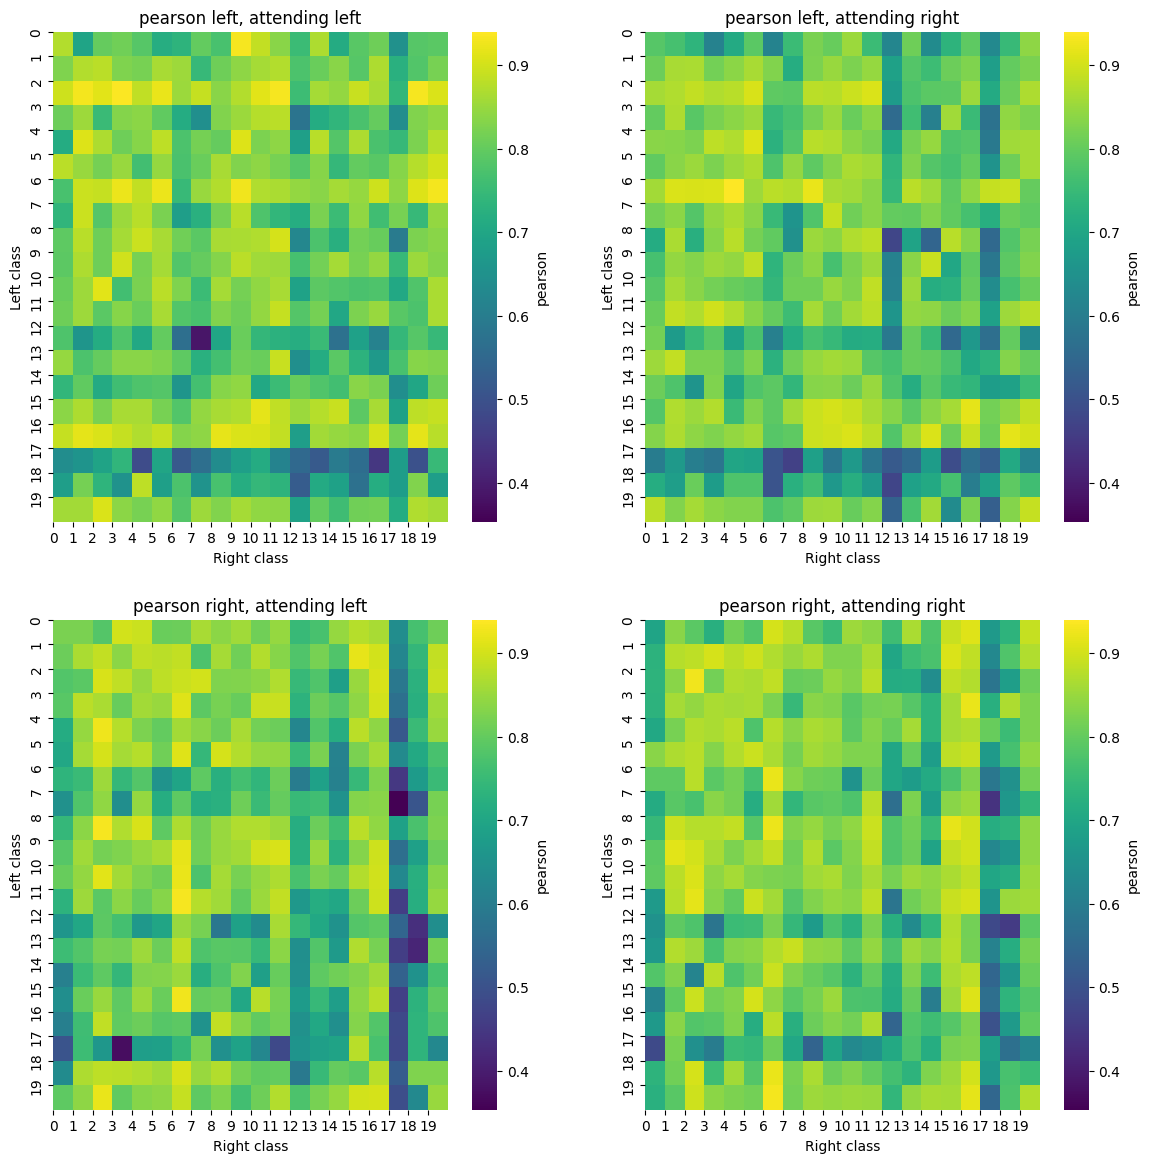

In [14]:
lowest_classes = [(np.int64(12), np.int64(18)), (np.int64(18), np.int64(12)), (np.int64(7), np.int64(18)), (np.int64(14), np.int64(18)), (np.int64(18), np.int64(7)), (np.int64(12), np.int64(8)), (np.int64(8), np.int64(12)), (np.int64(7), np.int64(8)), (np.int64(8), np.int64(7)), (np.int64(18), np.int64(15)), (np.int64(16), np.int64(12)), (np.int64(18), np.int64(14)), (np.int64(6), np.int64(18)), (np.int64(15), np.int64(18)), (np.int64(8), np.int64(14)), (np.int64(11), np.int64(7)), (np.int64(17), np.int64(18)), (np.int64(7), np.int64(11)), (np.int64(16), np.int64(7)), (np.int64(3), np.int64(12)), (np.int64(11), np.int64(12)), (np.int64(18), np.int64(17)), (np.int64(18), np.int64(6)), (np.int64(12), np.int64(10)), (np.int64(12), np.int64(11)), (np.int64(0), np.int64(18)), (np.int64(18), np.int64(2)), (np.int64(7), np.int64(10)), (np.int64(7), np.int64(16)), (np.int64(2), np.int64(18)), (np.int64(18), np.int64(0)), (np.int64(12), np.int64(6)), (np.int64(7), np.int64(1)), (np.int64(6), np.int64(8)), (np.int64(12), np.int64(16)), (np.int64(12), np.int64(1)), (np.int64(7), np.int64(19)), (np.int64(17), np.int64(8)), (np.int64(10), np.int64(7)), (np.int64(18), np.int64(13)), (np.int64(6), np.int64(12)), (np.int64(12), np.int64(19)), (np.int64(19), np.int64(12)), (np.int64(12), np.int64(5)), (np.int64(9), np.int64(12)), (np.int64(4), np.int64(18)), (np.int64(10), np.int64(12)), (np.int64(18), np.int64(4)), (np.int64(6), np.int64(17)), (np.int64(8), np.int64(17)), (np.int64(16), np.int64(17)), (np.int64(16), np.int64(15)), (np.int64(8), np.int64(6)), (np.int64(7), np.int64(9)), (np.int64(7), np.int64(5)), (np.int64(17), np.int64(6)), (np.int64(17), np.int64(16)), (np.int64(11), np.int64(14)), (np.int64(18), np.int64(5)), (np.int64(7), np.int64(6)), (np.int64(6), np.int64(10)), (np.int64(13), np.int64(18)), (np.int64(14), np.int64(8)), (np.int64(18), np.int64(3)), (np.int64(8), np.int64(0)), (np.int64(6), np.int64(5)), (np.int64(1), np.int64(7)), (np.int64(15), np.int64(8)), (np.int64(16), np.int64(14)), (np.int64(0), np.int64(8)), (np.int64(8), np.int64(2)), (np.int64(1), np.int64(12)), (np.int64(12), np.int64(3)), (np.int64(16), np.int64(0)), (np.int64(19), np.int64(7)), (np.int64(19), np.int64(6)), (np.int64(5), np.int64(7)), (np.int64(3), np.int64(7)), (np.int64(19), np.int64(17)), (np.int64(9), np.int64(7))]
# print(left_attleft[f'left_class_{0}'][f'right_class_{1}'].shape)
# print(len(left_input_SP_attleft_all))
# print(len(att_attleft))
# print(len(left_attleft))
# print(len(left_attleft[f'left_class_{0}'][f'right_class_{0}']))

#-------------pearson calculation----------------
lr_split_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': {
    'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []
    } for class_right in classes_right} for class_left in classes_left}

pearson_values = copy.deepcopy(lr_split_structure)
pearson_stdevs = copy.deepcopy(lr_split_structure)

pearson_start = time.time()
for class_left in classes_left:

    for class_right in classes_right: 

        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] == 0:  ##this makes sure you only calulate for left class pairs that have trials
            continue   

        for i in range(len(left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])):
            pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft'].append(pearsonr(left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'][i],
                                                                                                                      att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'][i])[0])
            pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft'].append(pearsonr(right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'][i],
                                                                                                                       att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'][i])[0])

print(f"pearson calculated for all left {class_left} in {pearson_start:.2f} seconds")

pearson_start = time.time()
for class_left in classes_left:
    for class_right in classes_right:

        if n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] == 0:  #right class pairs that have trials
            continue   

        for i in range(len(left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])):
            pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright'].append(pearsonr(left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'][i], att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'][i])[0])
            pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright'].append(pearsonr(right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'][i], att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'][i])[0])
                                                                                               
print(f"pearson calculated for all right {class_left} in {pearson_start:.2f} seconds")

       
print(pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft'])

run_time = time.time() - pearson_start
print(f"Total run time = {run_time:.2f} seconds")


#--------plotting the results-------------
results_to_plot = copy.deepcopy(lr_split_structure)

for class_left in classes_left:
    for class_right in classes_right:
        for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
            results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}'][key] = np.mean(pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}'][key])


results_to_plot_low =  copy.deepcopy(lr_split_structure)

for class_left in classes_left:
    for class_right in classes_right:
        if (class_left, class_right) in lowest_classes:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}'][key] = np.mean(pearson_values[f'left_class_{class_left}'][f'right_class_{class_right}'][key])
        else:
            for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']:
                results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}'][key] = -1


#==============================plotting heatmaps================================
def calculate_vmin_vmax(results_to_plot, classes_left, classes_right):
    vmax = np.max([results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}'][key] 
                   for class_left in classes_left for class_right in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    vmin = np.min([results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}'][key] 
                   for class_left in classes_left for class_right in classes_right for key in ['left_attleft', 'right_attleft', 'left_attright', 'right_attright']])
    return vmin, vmax


vmin, vmax = calculate_vmin_vmax(results_to_plot, classes_left, classes_right)


fig, ax = plt.subplots(2, 2, figsize=(14, 14))
sns.heatmap(np.array([[results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft'] for class_right in classes_right] for class_left in classes_left]),
             ax=ax[0, 0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[0,0].set_xticks(np.arange(0, 20))
ax[0,0].set_yticks(np.arange(0, 20))
ax[0,0].set_xticklabels(classes_right)
ax[0,0].set_yticklabels(classes_left)
ax[0,0].set_xlabel('Right class')
ax[0,0].set_ylabel('Left class')
ax[0,0].set_title(f'pearson left, attending left')

sns.heatmap(np.array([[results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft'] for class_right in classes_right] for class_left in classes_left]), 
             ax=ax[1,0], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[1,0].set_xticks(np.arange(0, 20))
ax[1,0].set_yticks(np.arange(0, 20))
ax[1,0].set_xticklabels(classes_right)
ax[1,0].set_yticklabels(classes_left)
ax[1,0].set_xlabel('Right class')
ax[1,0].set_ylabel('Left class')
ax[1,0].set_title(f'pearson right, attending left')

sns.heatmap(np.array([[results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright'] for class_right in classes_right] for class_left in classes_left]),
             ax=ax[0,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[0,1].set_xticks(np.arange(0, 20))
ax[0,1].set_yticks(np.arange(0, 20))
ax[0,1].set_xticklabels(classes_right)
ax[0,1].set_yticklabels(classes_left)
ax[0,1].set_xlabel('Right class')
ax[0,1].set_ylabel('Left class')
ax[0,1].set_title(f'pearson left, attending right')

sns.heatmap(np.array([[results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright'] for class_right in classes_right] for class_left in classes_left]),
             ax=ax[1,1], annot=False, fmt=".2f", cmap='viridis', cbar_kws={'label': 'pearson'}, vmin = vmin, vmax = vmax)
ax[1,1].set_xticks(np.arange(0, 20))
ax[1,1].set_yticks(np.arange(0, 20))
ax[1,1].set_xticklabels(classes_right)
ax[1,1].set_yticklabels(classes_left)
ax[1,1].set_xlabel('Right class')
ax[1,1].set_ylabel('Left class')
ax[1,1].set_title(f'pearson right, attending right')

plt.show()



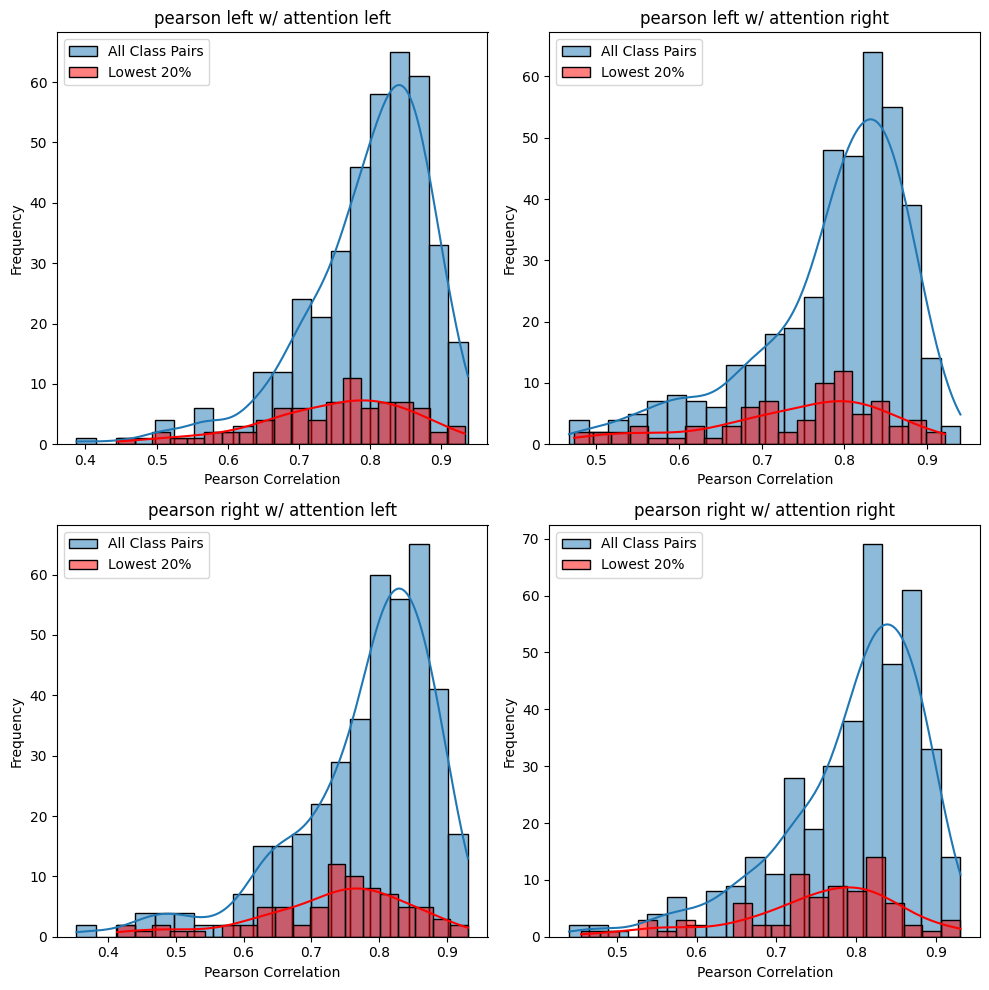

In [15]:
#==============================histograms================================
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the extracted wSMI values into 1D lists before plotting
hist_values_all = [results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft']
                      for class_left in classes_left for class_right in classes_right]
hist_values_low = [results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft']
                      for class_left in classes_left for class_right in classes_right if results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attleft'] != -1]

sns.histplot(hist_values_all, ax=ax[0, 0], bins=20, kde=True, label="All Class Pairs")
sns.histplot(hist_values_low, ax=ax[0, 0], bins=20, kde=True, label="Lowest 20%", color='red', alpha=0.5)
ax[0,0].set_title('pearson left w/ attention left')
ax[0,0].set_xlabel('Pearson Correlation')
ax[0,0].set_ylabel('Frequency')
ax[0,0].legend()

# Repeat for the other plots
hist_values_all = [results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft']
                      for class_left in classes_left for class_right in classes_right]
hist_values_low = [results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft']
                      for class_left in classes_left for class_right in classes_right if results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attleft'] != -1]

sns.histplot(hist_values_all, ax=ax[1, 0], bins=20, kde=True, label="All Class Pairs")
sns.histplot(hist_values_low, ax=ax[1, 0], bins=20, kde=True, label="Lowest 20%", color='red', alpha=0.5)
ax[1,0].set_title('pearson right w/ attention left')
ax[1,0].set_xlabel('Pearson Correlation')
ax[1,0].set_ylabel('Frequency')
ax[1,0].legend()

hist_values_all = [results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright']
                      for class_left in classes_left for class_right in classes_right]
hist_values_low = [results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright']
                      for class_left in classes_left for class_right in classes_right if results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['left_attright'] != -1]

sns.histplot(hist_values_all, ax=ax[0, 1], bins=20, kde=True, label="All Class Pairs")
sns.histplot(hist_values_low, ax=ax[0, 1], bins=20, kde=True, label="Lowest 20%", color='red', alpha=0.5)
ax[0,1].set_title('pearson left w/ attention right')
ax[0,1].set_xlabel('Pearson Correlation')
ax[0,1].set_ylabel('Frequency')
ax[0,1].legend()

hist_values_all = [results_to_plot[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright']
                      for class_left in classes_left for class_right in classes_right]
hist_values_low = [results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright']
                      for class_left in classes_left for class_right in classes_right if results_to_plot_low[f'left_class_{class_left}'][f'right_class_{class_right}']['right_attright'] != -1]

sns.histplot(hist_values_all, ax=ax[1, 1], bins=20, kde=True, label="All Class Pairs")
sns.histplot(hist_values_low, ax=ax[1, 1], bins=20, kde=True, label="Lowest 20%", color='red', alpha=0.5)
ax[1,1].set_title('pearson right w/ attention right')
ax[1,1].set_xlabel('Pearson Correlation')
ax[1,1].set_ylabel('Frequency')
ax[1,1].legend()

plt.tight_layout()
plt.show()